<a href="https://colab.research.google.com/github/sachinkatageri/ML_data_science/blob/master/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Requirement already up-to-date: gensim in /opt/conda/lib/python3.7/site-packages (3.8.3)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Requirement already up-to-date: keras in /opt/conda/lib/python3.7/site-packages (2.4.3)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (1.1.2)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path=("/content/drive/My Drive/Colab Notebooks/1.csv")
df = pd.read_csv(path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 497 ms, sys: 2.65 ms, total: 500 ms
Wall time: 504 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

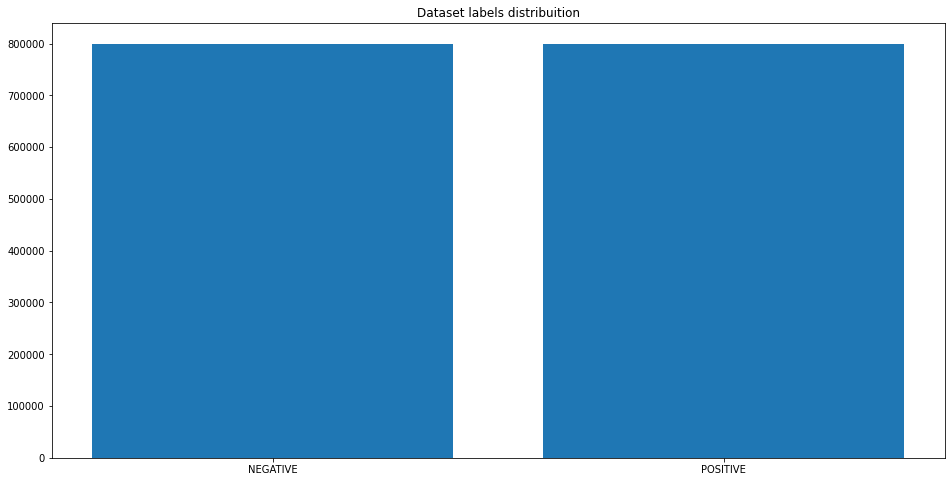

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 43.9 s, sys: 163 ms, total: 44.1 s
Wall time: 44.1 s


### Split train and test

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.05 s, sys: 483 ms, total: 3.53 s
Wall time: 3.54 s


In [21]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [22]:
w2v_model.build_vocab(documents)

2020-09-21 14:22:37,943 : INFO : collecting all words and their counts
2020-09-21 14:22:37,944 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-21 14:22:37,974 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-09-21 14:22:37,997 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-09-21 14:22:38,018 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-09-21 14:22:38,043 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-09-21 14:22:38,065 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-09-21 14:22:38,084 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-09-21 14:22:38,110 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-09-21 14:22:38,132 : INFO : PROGRESS: at s

In [23]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [24]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-09-21 14:22:56,430 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-09-21 14:22:57,489 : INFO : EPOCH 1 - PROGRESS: at 3.58% examples, 282610 words/s, in_qsize 15, out_qsize 1
2020-09-21 14:22:58,529 : INFO : EPOCH 1 - PROGRESS: at 8.15% examples, 321153 words/s, in_qsize 15, out_qsize 0
2020-09-21 14:22:59,529 : INFO : EPOCH 1 - PROGRESS: at 12.06% examples, 321067 words/s, in_qsize 14, out_qsize 1
2020-09-21 14:23:00,614 : INFO : EPOCH 1 - PROGRESS: at 16.70% examples, 329355 words/s, in_qsize 15, out_qsize 0
2020-09-21 14:23:01,615 : INFO : EPOCH 1 - PROGRESS: at 21.14% examples, 336238 words/s, in_qsize 15, out_qsize 0
2020-09-21 14:23:02,653 : INFO : EPOCH 1 - PROGRESS: at 25.26% examples, 334593 words/s, in_qsize 15, out_qsize 0
2020-09-21 14:23:03,664 : INFO : EPOCH 1 - PROGRESS: at 29.26% examples, 333393 words/s, in_qsize 16, out_qsize 0
2020-09-21 14:23:04,730 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 24min 54s, sys: 6.87 s, total: 25min 1s
Wall time: 12min 51s


(263129220, 295270528)

In [25]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-09-21 14:36:13,181 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5677887797355652),
 ('loves', 0.5675803422927856),
 ('loved', 0.552112340927124),
 ('adore', 0.5208165645599365),
 ('amazing', 0.5197292566299438),
 ('looove', 0.48692429065704346),
 ('awesome', 0.4634316563606262),
 ('loveee', 0.4628618061542511),
 ('lovee', 0.45064693689346313),
 ('loooove', 0.4381788969039917)]

### Tokenize Text

In [26]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 17.5 s, sys: 96 ms, total: 17.6 s
Wall time: 17.7 s


In [27]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 24.7 s, sys: 1.11 s, total: 25.8 s
Wall time: 25.8 s


### Label Encoder 

In [28]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [29]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [30]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [31]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [32]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [33]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [34]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Predict

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict("I love the music")

{'elapsed_time': 0.5802130699157715,
 'label': 'NEUTRAL',
 'score': 0.40379709005355835}

In [ ]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.05240505933761597,
 'elapsed_time': 0.0809934139251709}

In [41]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.11736583709716797,
 'label': 'NEUTRAL',
 'score': 0.5161680579185486}

### Confusion Matrix

In [38]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 2150s 54s/step
CPU times: user 26min 30s, sys: 26min, total: 52min 30s
Wall time: 36min 19s


In [42]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

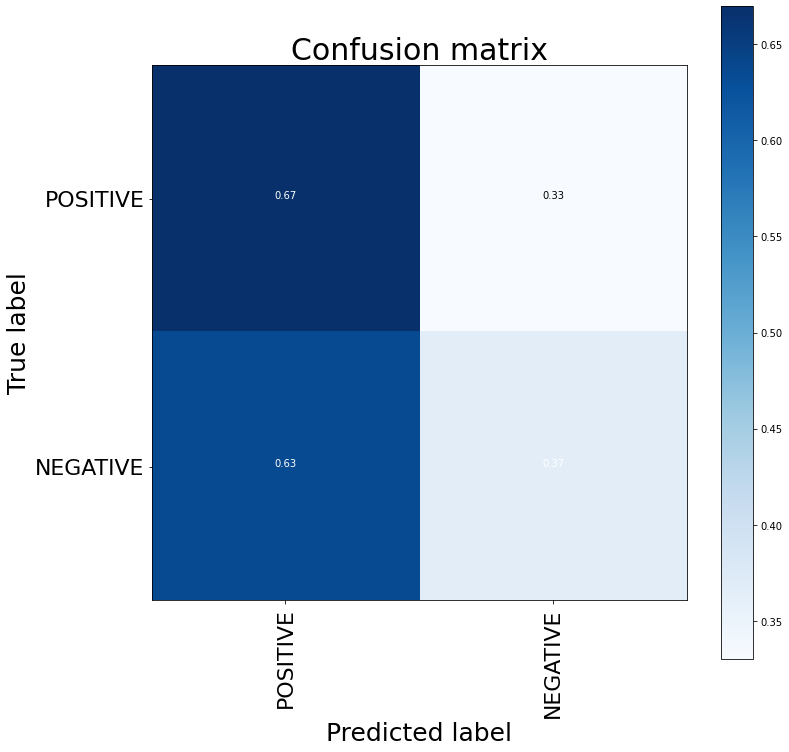

CPU times: user 1.22 s, sys: 13.9 ms, total: 1.24 s
Wall time: 1.24 s


In [43]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [44]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.51      0.67      0.58    159494
    POSITIVE       0.53      0.37      0.43    160506

    accuracy                           0.52    320000
   macro avg       0.52      0.52      0.51    320000
weighted avg       0.52      0.52      0.51    320000



### Accuracy Score

In [45]:
accuracy_score(y_test_1d, y_pred_1d)

0.517175